In [35]:
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [2]:
tf.keras.__version__

'2.2.4-tf'

In [3]:
tf.config.gpu.set_per_process_memory_growth(True)
# sess = tf.compat.v1.Session(config = config)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


## Loading datasets

Data source: https://www.kaggle.com/c/aerial-cactus-identification/data

### Move train set to subdirs for each class

In [4]:
%%bash 
unzip train.zip -d dataset/ > /dev/null 2>&1

In [5]:
train_dir = 'dataset/train/'
cactus_dir = os.path.join(train_dir, 'cactus')
no_cactus_dir = os.path.join(train_dir, 'no_cactus')

if not os.path.exists(cactus_dir):
    os.mkdir(cactus_dir)
    os.mkdir(no_cactus_dir)

train_csv_df = pd.read_csv('dataset/train.csv')
train_csv_df['label'] = train_csv_df.has_cactus.map({0: 'no_cactus', 1: 'cactus'})
train_csv_df['path'] =  train_dir + train_csv_df['label'] + '/' + train_csv_df['id']

train_csv_df.head()

,id,has_cactus,label,path
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1,cactus,dataset/train/cactus/0004be2cfeaba1c0361d39e2b...
1,000c8a36845c0208e833c79c1bffedd1.jpg,1,cactus,dataset/train/cactus/000c8a36845c0208e833c79c1...
2,000d1e9a533f62e55c289303b072733d.jpg,1,cactus,dataset/train/cactus/000d1e9a533f62e55c289303b...
3,0011485b40695e9138e92d0b3fb55128.jpg,1,cactus,dataset/train/cactus/0011485b40695e9138e92d0b3...
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1,cactus,dataset/train/cactus/0014d7a11e90b62848904c141...


In [6]:
train_csv_df.apply(lambda x: os.rename(os.path.join(train_dir, x[0]), x[3]), axis=1);

### Show image

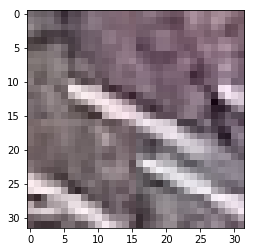

In [7]:
img = tf.keras.preprocessing.image.load_img(train_csv_df.loc[1, 'path'])
x = tf.keras.preprocessing.image.img_to_array(img)
plt.imshow(x/255.)

### Create Image Data Generator

In [50]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.,
    validation_split=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.1
)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=(32, 32), subset='training', batch_size=32, class_mode='binary')
valid_gen = train_datagen.flow_from_directory(train_dir, target_size=(32, 32), subset='validation', batch_size=32, class_mode='binary')

Found 15751 images belonging to 2 classes.
Found 1749 images belonging to 2 classes.


## Create model

In [51]:
clf = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
clf.compile('sgd', loss='binary_crossentropy', metrics=['accuracy'])

clf.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 256)             

Setting callbacks

In [52]:
filepath_to_best_model = 'model.h5'

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath=filepath_to_best_model, save_best_only=True)
]

In [53]:
batch_size = 64

history = clf.fit_generator(
    train_gen, 
    steps_per_epoch=int(train_gen.samples/batch_size),
    validation_data=valid_gen,
    validation_steps=int(valid_gen.samples/batch_size),
    epochs=100,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/100
246/246 [==============================] - 8s 32ms/step - loss: 0.5976 - accuracy: 0.7506 - val_loss: 0.5480 - val_accuracy: 0.7535
Epoch 2/100
246/246 [==============================] - 7s 29ms/step - loss: 0.5442 - accuracy: 0.7501 - val_loss: 0.5354 - val_accuracy: 0.7535
Epoch 3/100
246/246 [==============================] - 8s 31ms/step - loss: 0.5408 - accuracy: 0.7468 - val_loss: 0.5324 - val_accuracy: 0.7535
Epoch 4/100
246/246 [==============================] - 7s 29ms/step - loss: 0.5318 - accuracy: 0.7554 - val_loss: 0.5301 - val_accuracy: 0.7535
Epoch 5/100
246/246 [==============================] - 8s 31ms/step - loss: 0.5356 - accuracy: 0.7487 - val_loss: 0.5281 - val_accuracy: 0.7535
Epoch 6/100
246/246 [==============================] - 7s 29ms/step - loss: 0.5289 - accuracy: 0.7521 - val_loss: 0.5258 - val_accuracy: 0.7535
Epoch 7/100
246/246 [==============================] - 8s 31ms/step - loss: 0.5286 - accuracy: 0.7511 - val_loss: 0.5228 - val_accuracy:

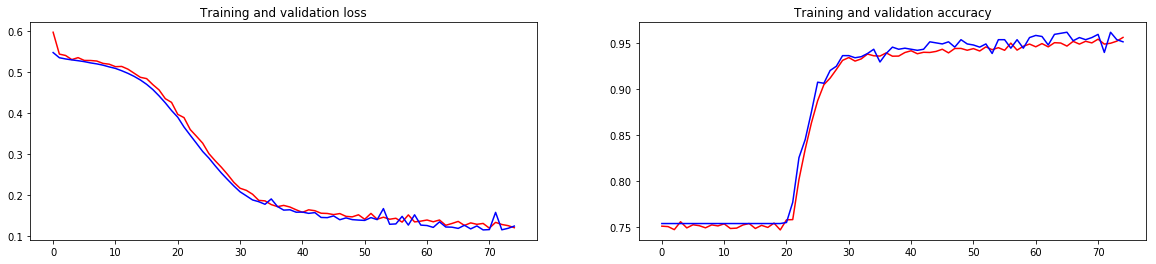

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
epochs = range(len(history.history['loss']))

axes[0].plot(epochs, history.history['loss'], 'r', label="Training Loss")
axes[0].plot(epochs, history.history['val_loss'], 'b', label="Validation Loss")
axes[0].set_title('Training and validation loss')

axes[1].plot(epochs, history.history['accuracy'], 'r', label="Training Accuracy")
axes[1].plot(epochs, history.history['val_accuracy'], 'b', label="Validation Accuracy")
axes[1].set_title('Training and validation accuracy');